# Initial work on how to produce case study figs for any MCS

Needs some work.

In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS

from remake import load_remake

In [2]:
tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                        PATHS['pixeldir'])
ntracks = len(tracks.dstracks.tracks)

In [3]:
time = dt.datetime(2019, 1, 5, 0, 30)
pdtime = pd.Timestamp(time)

In [4]:
ts = tracks.tracks_at_time(time)
frame = ts.pixel_data.get_frame(time)
tmask = (ts.dstracks.base_time == pdtime).values
cns = ts.dstracks.cloudnumber.values[tmask]
cns.sort()

In [5]:
year = 2019
month = 1
day = 5
e5datadir = PATHS['era5dir'] / f'data/oper/an_sfc/{year}/{month:02d}/{day:02d}'

e5cape = xr.open_mfdataset([e5datadir / f'ecmwf-era5_oper_an_sfc_{year}{month:02d}{day:02d}{h:02d}00.cape.nc' for h in [0, 1]]).cape.load()
e5cape = e5cape.sel(latitude=slice(60, -60)).isel(time=0)
pixel_precip = frame.dspixel.precipitation.isel(time=0)

In [6]:
ts

McsTracks[2019-01-01 00:30:00, 2019-01-06 13:30:00, ntracks=67]

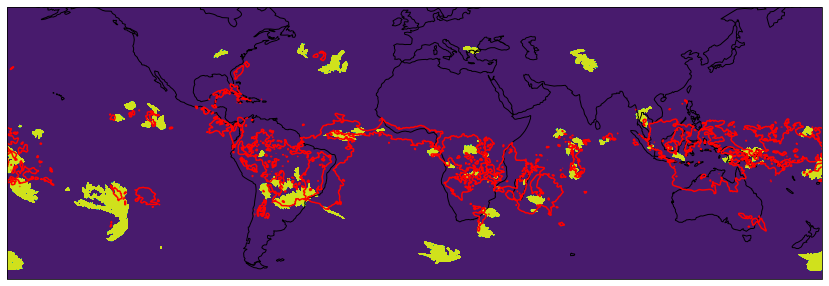

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

# https://stackoverflow.com/a/53561230/54557
e5cape.coords['longitude'] = (e5cape.coords['longitude'] + 180) % 360 - 180
e5cape = e5cape.sortby(e5cape.longitude)

fig.set_size_inches((20, 5))
# newlon = frame.dspixel.longitude.values % 180
ax.contourf(frame.dspixel.longitude.values, frame.dspixel.latitude, np.isin(frame.dspixel.cloudnumber.values[0], cns))
ax.contour(e5cape.longitude, e5cape.latitude, e5cape.values, levels=[500], colors=['r'])
ax.coastlines()
#plt.xlim((-80, -30));
#plt.ylim((-40, -10));


In [8]:
np.isin(frame.dspixel.cloudnumber.values[0], cns)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [9]:
cns

array([   2.,    4.,    5.,    6.,    8.,   11.,   13.,   14.,   19.,
         20.,   21.,   22.,   25.,   27.,   28.,   29.,   30.,   35.,
         37.,   39.,   40.,   43.,   47.,   49.,   50.,   51.,   52.,
         53.,   54.,   57.,   58.,   60.,   62.,   63.,   66.,   68.,
         70.,   71.,   73.,   74.,   77.,   79.,   89.,   96.,   98.,
        103.,  106.,  123.,  135.,  143.,  159.,  168.,  171.,  173.,
        193.,  195.,  222.,  224.,  243.,  306.,  336.,  354.,  359.,
        399.,  495.,  836., 1058.])

In [10]:
mcs_mask = frame.dspixel.cloudnumber.values[0] == 2

In [11]:
mcs_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [12]:
# https://stackoverflow.com/a/31402351/54557
def bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def extent(lon, lat, mask):
    rmin, rmax, cmin, cmax = bbox(mask)
    return lon[cmin], lon[cmax], lat[rmin], lat[rmax]

In [13]:
extent(frame.dspixel.lon.values, frame.dspixel.lat.values, mcs_mask)

(-150.35, -126.35, -43.25, -17.15)

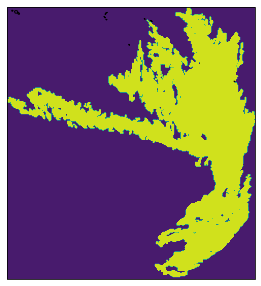

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

fig.set_size_inches((20, 5))
# newlon = frame.dspixel.longitude.values % 180
ax.contourf(frame.dspixel.longitude.values, frame.dspixel.latitude, mcs_mask)
ax.coastlines()
ax.set_extent(extent(frame.dspixel.lon.values, frame.dspixel.lat.values, mcs_mask))

In [15]:
ts

McsTracks[2019-01-01 00:30:00, 2019-01-06 13:30:00, ntracks=67]

In [16]:
ts.dstracks.tracks

<xarray.DataArray 'tracks' (tracks: 67)>
array([  6, 230, 249, 256, 283, 284, 285, 287, 290, 295, 298, 299, 301, 302,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 323, 328,
       329, 330, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
       345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369])
Coordinates:
  * tracks   (tracks) int64 6 230 249 256 283 284 ... 364 365 366 367 368 369

In [17]:
track = ts.get_track(ts.dstracks.tracks.values[0])

In [18]:
track.cloudnumber

array([ 10.,   8.,   7.,  11.,  10.,   9.,  13.,  12.,  11.,   9.,  11.,
        15.,  16.,  17.,  27.,  10.,  13.,   8.,   9.,   7.,   8.,   7.,
         7.,   8.,   9.,   9.,  18.,  12.,  13.,  19.,  19.,   6.,  18.,
         9.,  24.,  47.,  33.,  32.,  32.,  32.,  34.,  28.,  20.,  22.,
        19.,  20.,  18.,  24.,  26.,  20.,  20.,  21.,  20.,  24.,  26.,
        19.,  18.,  17.,  15.,  16.,  24.,  21.,  16.,  13.,  14.,  11.,
         8.,   9.,  10.,  11.,   7.,   9.,  12.,  15.,  14.,  13.,  13.,
        13.,  13.,  13.,  14.,  16.,  22.,  21.,  23.,  24.,  24.,  22.,
        21.,  20.,  16.,  20.,  19.,  29.,  20.,  24.,  29.,  29.,  36.,
        42.,  42.,  45.,  63.,  59.,  51.,  37.,  48.,  57.,  57.,  50.,
        50., 105., 618., 348., 406.])

2019-01-01 00:30:00
2019-01-01 01:30:00
2019-01-01 02:30:00
2019-01-01 03:30:00
2019-01-01 04:30:00


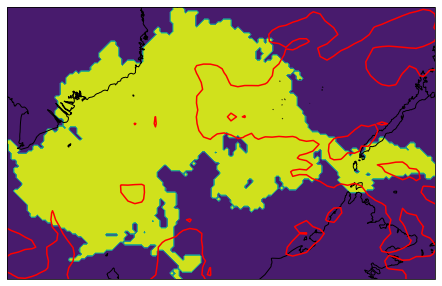

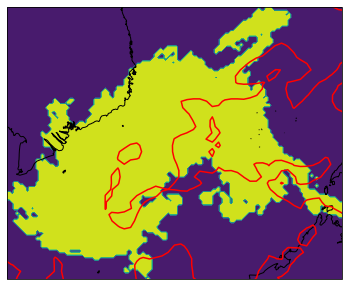

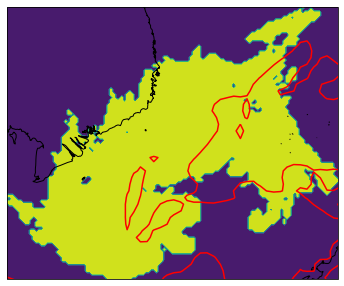

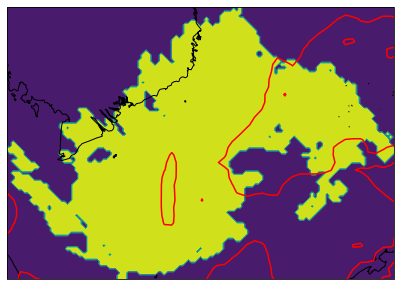

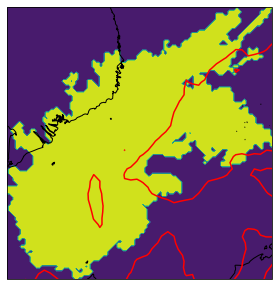

In [19]:
for cn, pdtime in zip(track.cloudnumber[:5], pd.DatetimeIndex(track.base_time)):
    time = pdtime.to_pydatetime()
    print(time)
    frame = ts.pixel_data.get_frame(time)
    
    mcs_mask = frame.dspixel.cloudnumber.values[0] == cn
    e5cape = xr.open_mfdataset([(PATHS['era5dir'] / f'data/oper/an_sfc/{t.year}/{t.month:02d}/{t.day:02d}' / 
                                 f'ecmwf-era5_oper_an_sfc_{t.year}{t.month:02d}{t.day:02d}{t.hour:02d}00.cape.nc')
                                 for t in [time - dt.timedelta(minutes=30), time + dt.timedelta(minutes=30)]]).cape.load()
    e5cape = e5cape.sel(latitude=slice(60, -60)).isel(time=0)
    # https://stackoverflow.com/a/53561230/54557
    e5cape.coords['longitude'] = (e5cape.coords['longitude'] + 180) % 360 - 180
    e5cape = e5cape.sortby(e5cape.longitude)
    
    pixel_precip = frame.dspixel.precipitation.isel(time=0)
    
    fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
    fig.set_size_inches((20, 5))
    
    ax.contourf(frame.dspixel.longitude.values, frame.dspixel.latitude, mcs_mask)
    ax.contour(e5cape.longitude, e5cape.latitude, e5cape.values, levels=[500], colors=['r'])

    ax.coastlines()
    ax.set_extent(extent(frame.dspixel.lon.values, frame.dspixel.lat.values, mcs_mask))
